In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, ZeroPadding2D, MaxPooling2D, AvgPool2D, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model

In [28]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    """First component of main path"""
    # CONV2D
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    # ReLU
    X = Activation('relu')(X)

    """Second component of main path"""
    # CONV2D
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    # ReLU
    X = Activation('relu')(X)

    """Third component of main path"""
    # CONV2D
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    """Final step: Add shortcut value to main path, and pass it through a RELU activation"""
    # SKIP Connection
    X = Add()([X, X_shortcut])
    # ReLU
    X = Activation('relu')(X)

    return X

In [29]:
def convolutional_block(X, f, filters, stage, block, s=2):

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    """First component of main path"""
    # CONV2D
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    # ReLU
    X = Activation('relu')(X)

    """Second component of main path"""
    # CONV2D
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    # ReLU
    X = Activation('relu')(X)

    """Third component of main path"""
    # CONV2D
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    """Shortcut Path"""
    # Shortcut CONV2D
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    # Shortcut Batch Norm
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    """Final step: Add shortcut value to main path, and pass it through a RELU activation"""
    # Shortcut or Skip Connection
    X = Add()([X, X_shortcut])
    # ReLU
    X = Activation('relu')(X)

    return X

In [30]:
def ResNet50(input_shape=(224, 224, 3)):

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # ZERO PAD
    X = ZeroPadding2D((3, 3))(X_input)


    """Stage 1"""
    # CONV
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    # ReLU
    X = Activation('relu')(X)
    # MAX POOL
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)


    """Stage 2"""
    # CONV BLOCK
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    # ID BLOCK x2
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')



    """Stage 3"""
    # CONV BLOCK
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    # ID BLOCK x3
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')


    """Stage 4"""
    # CONV BLOCK
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    # ID BLOCK x5
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')


    """Stage 5"""
    # CONV BLOCK
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    # ID BLOCK x2
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL. Use "X = AveragePooling2D(...)(X)"
    X = AvgPool2D(pool_size=(2, 2), padding='same')(X)

    # Create Model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    # return ResNet50 as model
    return model

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import tensorflow as tf
from matplotlib import pyplot as plt

In [32]:
train_generate = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2])   #test klasöründen çekemediğim için train verisetinden testlik bir kısım almam gerekti

train_datas = train_generate.flow_from_directory(
    'datasets/realfakedataset_HARD/train', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 901 images belonging to 2 classes.


In [33]:
validation_generate = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

validation_datas = validation_generate.flow_from_directory(
    'datasets/realfakedataset_HARD/validation', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 258 images belonging to 2 classes.


In [34]:
test_generate = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datas = test_generate.flow_from_directory(
    'datasets/realfakedataset_HARD/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Type of class labels
    shuffle=False)

Found 130 images belonging to 2 classes.


In [36]:
base_model = ResNet50(input_shape = (224, 224, 3))

In [42]:
head_model = base_model.output

# Flatten the output of our model
head_model = Flatten()(head_model)

# Constructing fully connected layer
head_model = Dense(256, activation='relu', name='fc1', kernel_initializer=glorot_uniform(seed=0))(head_model)
head_model = Dense(128, activation='relu', name='fc2', kernel_initializer=glorot_uniform(seed=0))(head_model)
head_model = Dense(2, activation='softmax', name='fc3', kernel_initializer=glorot_uniform(seed=0))(head_model)

In [47]:
model = Model(
    inputs = base_model.input,
    outputs = head_model
)

In [48]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_2              │ (None, 230, 230, 3)       │               0 │ input_layer_9[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1 (Conv2D)                │ (None, 112, 112, 64)      │           9,472 │ zero_padding2d_2[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_conv1 (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_49 (Activation)    │ (None, 112, 112, 64)      │               0 │ bn_conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 55, 55, 64)        │               0 │ activation_49[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2a (Conv2D)       │ (None, 55, 55, 64)        │           4,160 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2a_branch2a                 │ (None, 55, 55, 64)        │             256 │ res2a_branch2a[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_50 (Activation)    │ (None, 55, 55, 64)        │               0 │ bn2a_branch2a[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2b (Conv2D)       │ (None, 55, 55, 64)        │          36,928 │ activation_50[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2a_branch2b                 │ (None, 55, 55, 64)        │             256 │ res2a_branch2b[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_51 (Activation)    │ (None, 55, 55, 64)        │               0 │ bn2a_branch2b[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2c (Conv2D)       │ (None, 55, 55, 256)       │          16,640 │ activation_51[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch1 (Conv2D)        │ (None, 55, 55, 256)       │          16,640 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2a_branch2c                 │ (None, 55, 55, 256)       │           1,024 │ res2a_branch2c[0][0]       │
│ (BatchNormalization)          │                           │               

 Total params: 32,009,730 (122.11 MB)

 Trainable params: 31,956,610 (121.90 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [51]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0003)
model.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [52]:
logdir = 'resnet_logs_hard' #eğitimle ilgili logların tutulacağı bir klasör oluşturuyoruz
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [53]:
hist = model.fit(train_datas, epochs=21, validation_data=validation_datas, callbacks=[tensorboard_callback])

Epoch 1/21


C:\Users\ilayd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 299s 8s/step - accuracy: 0.5167 - loss: 3.2933 - val_accuracy: 0.5426 - val_loss: 0.7402
Epoch 2/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 222s 7s/step - accuracy: 0.5699 - loss: 1.2611 - val_accuracy: 0.4574 - val_loss: 0.7018
Epoch 3/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 219s 7s/step - accuracy: 0.5509 - loss: 0.9100 - val_accuracy: 0.5426 - val_loss: 0.7032
Epoch 4/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 220s 7s/step - accuracy: 0.5360 - loss: 1.0370 - val_accuracy: 0.5426 - val_loss: 0.6992
Epoch 5/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 219s 7s/step - accuracy: 0.6327 - loss: 0.9813 - val_accuracy: 0.5426 - val_loss: 0.6999
Epoch 6/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 223s 8s/step - accuracy: 0.6840 - loss: 0.8304 - val_accuracy: 0.4574 - val_loss: 1.1355
Epoch 7/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 220s 7s/step - accuracy: 0.6929 - loss: 0.7763 - val_accuracy: 0.4419 - val_loss: 0.7977
Epoch 8/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 219s 7s/step - accuracy: 0.7676 - loss: 0.5132 - val_accuracy: 0.5620 - val_loss: 0.

In [54]:
hist.history

{'accuracy': [0.49833518266677856,
  0.5549389719963074,
  0.5660377144813538,
  0.5771365165710449,
  0.6115427017211914,
  0.6825749278068542,
  0.6914539337158203,
  0.7713651657104492,
  0.7968923449516296,
  0.8213096857070923,
  0.8423973321914673,
  0.8679245114326477,
  0.8623751401901245,
  0.8024417161941528,
  0.861265242099762,
  0.8712541460990906,
  0.8679245114326477,
  0.902330756187439,
  0.9178690314292908,
  0.9389567375183105,
  0.9300776720046997],
 'loss': [2.895632028579712,
  1.1366350650787354,
  0.9304144382476807,
  0.9444490075111389,
  0.9697907567024231,
  0.8197856545448303,
  0.7426417469978333,
  0.5071516036987305,
  0.5047314167022705,
  0.4340812861919403,
  0.39837294816970825,
  0.33368000388145447,
  0.33680400252342224,
  0.4830667972564697,
  0.33223414421081543,
  0.3088688254356384,
  0.3204127252101898,
  0.25907906889915466,
  0.1892346292734146,
  0.18266184628009796,
  0.17223438620567322],
 'val_accuracy': [0.5426356792449951,
  0.4573643

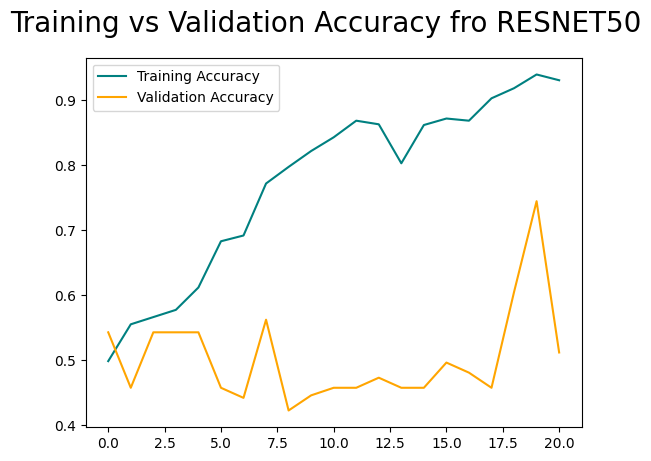

In [62]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
fig.suptitle('Training vs Validation Accuracy fro RESNET50', fontsize=20)
plt.legend(loc="upper left")
plt.show()

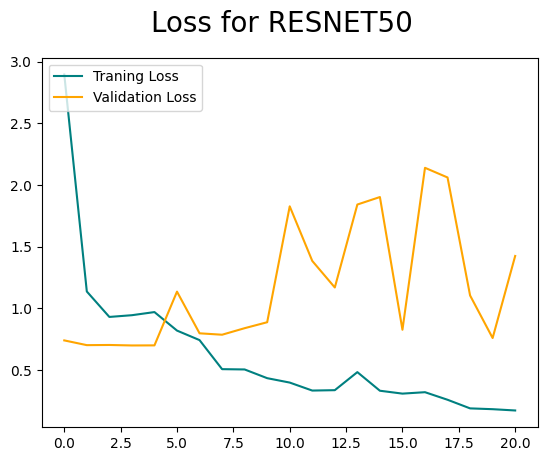

In [63]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Traning Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation Loss')
fig.suptitle('Loss for RESNET50', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [61]:
import os
model.save(os.path.join('shufflenet_models/forharddataset', 'resnetmodeloverfit.h5'))

In [57]:
import numpy as np
num_batches = len(test_datas)
batch_size = test_datas.batch_size
total_samples = test_datas.samples

# Calculate the number of steps (batches)
steps = total_samples // batch_size
if total_samples % batch_size != 0:
    steps += 1  # If there are remaining samples, add one more step

# Initialize lists to hold true and predicted labels
y_true = []
y_pred = []

# Iterate over the test data
for step in range(steps):
    X, y = next(test_datas)
    yhat = model.predict(X)
    y_true.extend(np.argmax(y, axis=1))  # Assuming y is one-hot encoded
    y_pred.extend(np.argmax(yhat, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)

precision = precision_score(y_true, y_pred, average='binary') 

recall = recall_score(y_true, y_pred, average='binary')  

f1 = f1_score(y_true, y_pred, average='binary')  

cm = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{cm}")

Accuracy: 0.4846153846153846
Precision: 0.46825396825396826
Recall: 1.0
F1 Score: 0.6378378378378379
Confusion Matrix:
[[ 4 67]
 [ 0 59]]


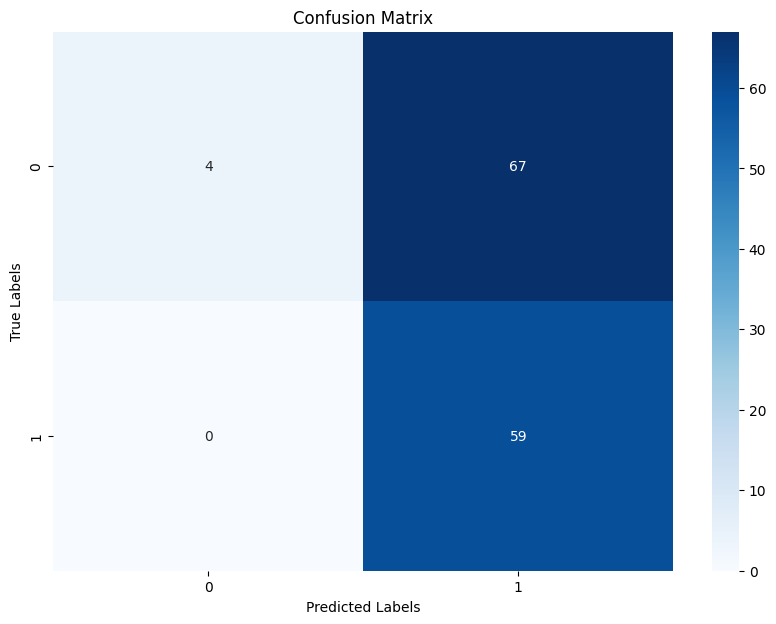

In [59]:
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()